<a href="https://www.kaggle.com/code/zeyadusf/llms-from-scratch?scriptVersionId=195199354" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction 

*This notebook aims to: Apply what i learned from the book "**Build a Large Language Model (From Scratch)**" in one place and I will collect what you learned from the book and some important notes that enable you to understand and build large language models.*

- **My repo on github**: 
- **official repo of the book**

 <h1 style="background-color:#0D7C66; color:white; font-family:Gabriola; text-align:center; border-radius:50px; padding:20px 40px; font-size:48px;">
  What is an LLM?
</h1>

> An LLM, a large language model, is a neural network designed to
understand, generate, and respond to human-like text. These models are deep
neural networks trained on massive amounts of text data, sometimes
encompassing large portions of the entire publicly available text on the
internet.

> The **"large"** in large language model refers to both the model's size in terms
of parameters and the immense dataset on which it's trained. Models like this
often have tens or even hundreds of billions of parameters, which are the
adjustable weights in the network that are optimized during training to predict
the next word in a sequence. Next-word prediction is sensible because it
harnesses the inherent sequential nature of language to train models on
understanding context, structure, and relationships within text.



<div style="text-align: center;">
  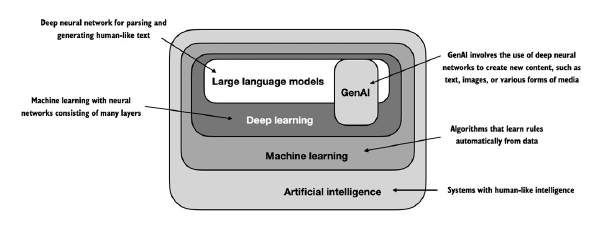
</div>


## We will take the fundamental idea behind GPT as a blueprint and tackle this in three stages


<div style="text-align: center;">
  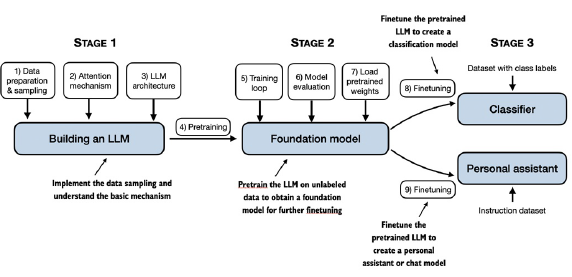
</div>


<hr>

# Setup Environment

first we install and import libraries and initial all variables can be use all time in project

In [1]:
%%time
!pip install --upgrade --quiet tiktoken

CPU times: user 226 ms, sys: 43.9 ms, total: 269 ms
Wall time: 13.3 s


In [2]:
# Import Libraries 
import numpy as np
import torch 
from torch.utils.data import Dataset, DataLoader
from torch import nn 
import tiktoken as ttk

from tqdm import tqdm
import os
import urllib.request
from dataclasses import dataclass, field,asdict, replace

from typing import Dict



In [3]:
# get raw text we want to work with from official repo 
if not os.path.exists("the-verdict.txt"):
    url = ("https://raw.githubusercontent.com/rasbt/"
           "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
           "the-verdict.txt")
    file_path = "the-verdict.txt"
    urllib.request.urlretrieve(url, file_path)

In [4]:
@dataclass
class GPTConfig:
    vocab_size: int = 50257
    context_length: int = 512
    emb_dim: int = 768
    n_heads: int = 12
    n_layers: int = 12
    drop_rate: float = 0.1
    qkv_bias: bool = False

    def to_dict(self) -> dict:
        return asdict(self)

    def __repr__(self) -> str:
        config_dict = self.to_dict()
        formatted_items = [f'"{key}": {repr(value)}' for key, value in config_dict.items()]
        return "GPT_CONFIG_124M = {\n    " + ",\n    ".join(formatted_items) + "\n}"

@dataclass
class DataConfig:
    dataPath: str =r'/kaggle/working/the-verdict.txt'
    max_length: int = GPTConfig.context_length
    batch_size: int = 64
    train_ratio : float = 0.90
    stride: int = GPTConfig.context_length
#     def __post_init__(self):
#         self.stride = self.max_length // 2
DataConfig =DataConfig()
GPTConfig=GPTConfig()
device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
def read_txt(path: str) -> str:
    try:
        with open(path, "r", encoding="utf-8") as f:
            raw_text = f.read()
        return raw_text
    except FileNotFoundError:
        print(f"Error: File not found at {path}")
        return ""
    except Exception as e:
        print(f"An error occurred: {e}")
        return ""
def text_to_token_ids(text, tokenizer):
    tokens = tokenizer.encode(text)
    return torch.tensor(tokens, dtype=torch.long)  # Ensure this is compatible with the device in use


def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text)
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # add batch dimension
    return encoded_tensor


def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)  # remove batch dimension
    return tokenizer.decode(flat.tolist())

 <h1 style="background-color:#0D7C66; color:white; font-family:Gabriola; text-align:center; border-radius:50px; padding:20px 40px; font-size:48px;">
 Stage 1
</h1>
 <h2 style="background-color:#41B3A2; color:white; font-family:Gabriola; text-align:center; border-radius:50px; padding:15px 10px; font-size:38px;">
1) Data preparation and Sampling</h2 >


<h3> What is covered in this chapter of the book?</h3>

>1.Understanding word embeddings:
> - here are many forms of embeddings
> - LLMs work with embeddings in high-dimensional spaces (i.e., thousands of dimensions)
> - Since we can't visualize such high-dimensional spaces (we humans think in 1, 2, or 3 dimensions), the figure below illustrates a 2-dimensional embedding space

>2.Tokenizing text
> - which means breaking text into smaller units, such as individual words and punctuation characters.
> - develop a simple tokenizer based on some simple sample text that we can then later apply to the text above.

>3.Converting tokens into token IDs:
> - convert the text tokens into token IDs that we can process via embedding layers later
> - From these tokens, we can now build a vocabulary that consists of all the unique tokens.

>4.Adding special context tokens:
> - "special" tokens for unknown words and to denote the end of a text

>5.BytePair encoding:
> - GPT-2 used BytePair encoding (BPE) as its tokenizer
> - it allows the model to break down words that aren't in its predefined vocabulary into smaller subword units or even individual characters, enabling it to handle out-of-vocabulary words
> - For instance, if GPT-2's vocabulary doesn't have the word "unfamiliarword," it might tokenize it as ["unfam", "iliar", "word"] or some other subword breakdown, depending on its trained BPE merges
> - The original BPE tokenizer can be found here: https://github.com/openai/gpt-2/blob/master/src/encoder.py

**In Project , we are using the BPE tokenizer from OpenAI's open-source tiktoken library.**

>6.Data Sampling:
> - We train LLMs to generate one word at a time, so we want to prepare the training data accordingly where the next word in a sequence represents the target to predict

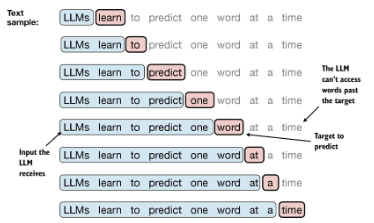

In [6]:

class LLMDataset(Dataset):
    """
    A custom Dataset for processing text data into input and target sequences for language modeling.

    Args:
        txt (str): The input text to be tokenized and processed.
        tokenizer (Tokenizer): The tokenizer to be used for encoding the text.
        max_length (int): The maximum length of each input sequence.
        stride (int): The number of tokens to skip between sequences.
    """

    def __init__(self, txt, tokenizer, max_length: int, stride: int):
        self.tokenizer = tokenizer
        token_ids = tokenizer.encode(txt)
        self.input_ids = []
        self.target_ids = []
        
        for i in tqdm(range(0, len(token_ids) - max_length, stride)):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1:i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        """
        Returns the number of samples in the dataset.
        """
        return len(self.input_ids)

    def __getitem__(self, idx):
        """
        Retrieves the input and target sequence at the specified index.

        Args:
            idx (int): The index of the sequence to retrieve.

        Returns:
            tuple: (input_ids, target_ids) where both are tensors.
        """
        return self.input_ids[idx], self.target_ids[idx]


def LLM_DataLoader(txt, tokenizer, batch_size: int, max_length: int, stride: int,
                   shuffle: bool = True, drop_last: bool = True):
    """
    Creates a DataLoader for the LLMDataset.

    Args:
        txt (str): The input text to be tokenized and processed.
        tokenizer (Tokenizer): The tokenizer to be used for encoding the text.
        batch_size (int): The number of samples per batch to load.
        max_length (int): The maximum length of each input sequence.
        stride (int): The number of tokens to skip between sequences.
        shuffle (bool, optional): Whether to shuffle the data at every epoch. Defaults to True.
        drop_last (bool, optional): Whether to drop the last incomplete batch. Defaults to True.

    Returns:
        DataLoader: A DataLoader instance for the LLMDataset.
    """
    llmdataset = LLMDataset(txt, tokenizer, max_length, stride)
    llmdataloader = DataLoader(llmdataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
    return llmdataloader


In [7]:
# now let's load the-verdict.txt and make instance from tiktoken
raw_data = read_txt(DataConfig.dataPath)
tokenizer = ttk.get_encoding("gpt2") 

total_token = len(tokenizer.encode(raw_data))
print(f"-> Number of Characters : {len(raw_data)}\n-> Number of Tokens : {total_token}")

-> Number of Characters : 20479
-> Number of Tokens : 5145


In [8]:
# next, Split the data into training and Validation
train_ratio = DataConfig.train_ratio
split_idxs = int(train_ratio * len(raw_data))
train_data = raw_data[:split_idxs]
val_data = raw_data[split_idxs:]
print(f'-> Length of training data : {len(train_data)}\n-> Length of val_data : {len(val_data)}')


# Sanity check
if total_token * (train_ratio) < GPTConfig.context_length:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPTConfig.context_length or "
          "increase the `training_ratio`")

if total_token * (1-train_ratio) < GPTConfig.context_length:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPTConfig.context_length` or "
          "decrease the `training_ratio`")

-> Length of training data : 18431
-> Length of val_data : 2048


In [9]:
# let's process data to can use as input for LLMs
train_dataloader = LLM_DataLoader(
  txt= train_data,
  tokenizer = tokenizer,
  max_length = DataConfig.max_length,
  batch_size =  DataConfig.batch_size,
  stride =  DataConfig.stride,
  shuffle=False,
  drop_last = False
)

print("View example:")
dataiter = iter(train_dataloader)
firstbatch =next(dataiter)
print(f'inputs: \n{firstbatch[0]} \ntarget: \n{firstbatch[1]}')
firstbatch[0].shape

100%|██████████| 9/9 [00:00<00:00, 2076.16it/s]

View example:
inputs: 
tensor([[   40,   367,  2885,  ...,  9074,    13,   402],
        [  271, 10899,   550,  ...,   691, 12226,   318],
        [  284,  1234,  8737,  ..., 19217, 24887, 13431],
        ...,
        [ 1310,  1165,   881,  ...,   514,  2474,   198],
        [  198,  1544, 13818,  ...,   284,   616,   835],
        [  286,  1762,    30,  ...,  1517,   484,  1444]]) 
target: 
tensor([[  367,  2885,  1464,  ...,    13,   402,   271],
        [10899,   550,   366,  ..., 12226,   318,   284],
        [ 1234,  8737,   656,  ..., 24887, 13431,    13],
        ...,
        [ 1165,   881, 40642,  ...,  2474,   198,   198],
        [ 1544, 13818,  4622,  ...,   616,   835,   286],
        [ 1762,    30,  2011,  ...,   484,  1444,   616]])


torch.Size([9, 512])

In [10]:
val_dataloader = LLM_DataLoader(
  txt= val_data,
  tokenizer = tokenizer,
  max_length = DataConfig.max_length,
  batch_size =  DataConfig.batch_size,
  stride =  DataConfig.stride,
  shuffle=False,
  drop_last = False
)
dataiter = iter(val_dataloader)
firstbatch =next(dataiter)
firstbatch[0].shape

100%|██████████| 1/1 [00:00<00:00, 1822.82it/s]


torch.Size([1, 512])

**Now the data is ready for training...**

 <h2 style="background-color:#41B3A2; color:white; font-family:Gabriola; text-align:center; border-radius:50px; padding:15px 10px; font-size:38px;">
2) Attention Mechanism</h2 >

**This chapter covers**

> - Exploring the reasons for using attention mechanisms in neural networks.
-Introducing a basic self-attention framework and progressing to an enhanced self-attention mechanism.
-Implementing a causal attention module that allows LLMs to generate one token at a time.
-Masking randomly selected attention weights with dropout to reduce overfitting.
-Stacking multiple causal attention modules into a multi-head attention module.

### Abstract about attention:
>The attention mechanism is a pivotal concept in modern deep learning, particularly within the realm of natural language processing (NLP) and computer vision. It enables models to dynamically focus on specific parts of the input data, much like how humans pay attention to relevant information while processing complex tasks.

>Introduced by Bahdanau et al. in the context of machine translation, attention mechanisms allow models to weigh the importance of different input elements, enabling better handling of long-range dependencies in sequences. This mechanism computes a set of attention weights that determine the relevance of each part of the input in relation to the current task, allowing the model to attend to the most pertinent information.

>Attention has evolved into various forms, including self-attention, which underpins the Transformer architecture. Self-attention allows a model to consider all parts of a sequence simultaneously, enhancing its ability to capture relationships between distant elements in the input. This has led to significant advances in NLP, as seen in models like BERT, GPT, and T5.

>In computer vision, attention mechanisms have been adapted to improve the performance of tasks such as image classification, object detection, and image generation. Here, attention enables models to focus on relevant spatial regions within an image, thereby improving accuracy and interpretability.

>Overall, the attention mechanism has revolutionized the way models process and understand complex data, leading to state-of-the-art performance across a variety of AI tasks.

<br>

**- there are  four different variants of attention mechanisms:**

<div style="text-align: center;">
  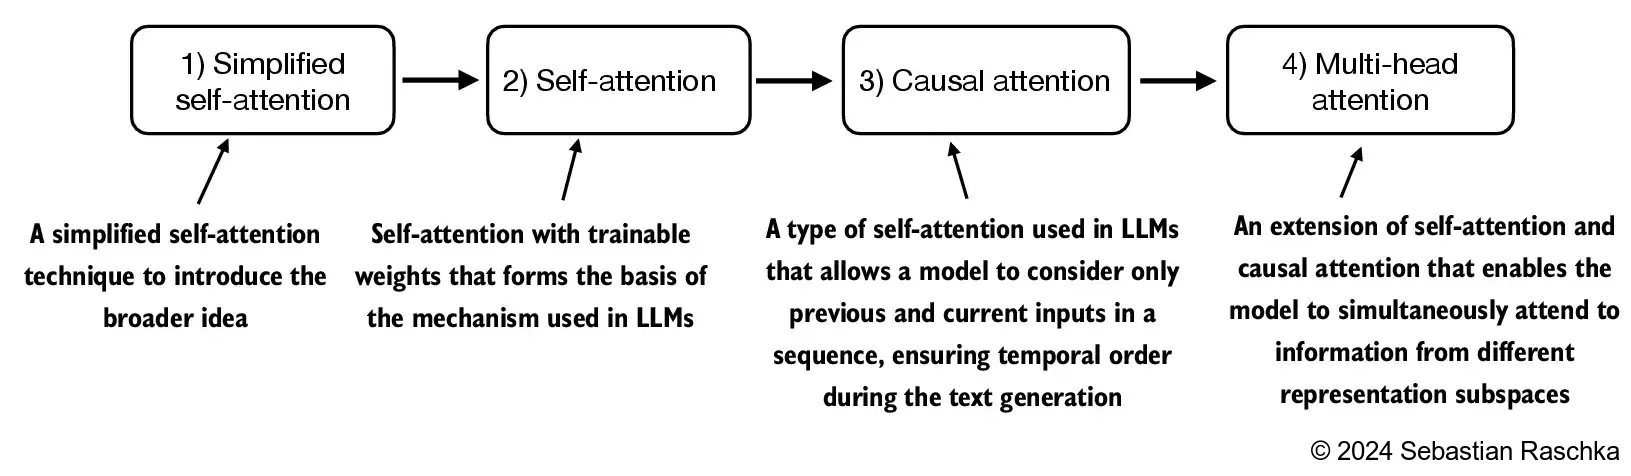
</div>


### Multi-head Attention:
>Multi-head attention is a core component of the Transformer architecture, designed to enhance the capability of the attention mechanism by allowing the model to focus on different parts of the input simultaneously. Introduced by Vaswani et al. in the paper "Attention is All You Need," multi-head attention enables the model to capture diverse relationships in the data by applying multiple attention mechanisms in parallel.

>In a single attention mechanism, an input sequence is transformed into three vectors: Query (Q), Key (K), and Value (V). The attention scores are computed as the dot product between the Query and Key vectors, which are then used to weigh the Value vectors, highlighting the most relevant parts of the input.

>Multi-head attention extends this idea by creating multiple sets of Query, Key, and Value vectors, each corresponding to a different "head." These heads are independent of each other and can learn to focus on different aspects of the input. For instance, one head might focus on local context, while another might capture long-range dependencies. After computing attention scores for each head, the results are concatenated and linearly transformed to produce the final output.

>This approach offers several advantages:
>-Parallelism: By using multiple attention heads, the model can simultaneously process different parts of the input, leading to richer feature representations.
>-Diversification: Each head can learn to attend to different parts of the input, enabling the model to capture a wider range of relationships within the data.
>-Improved Generalization: Multi-head attention reduces the risk of overfitting by distributing the learning process across multiple heads, each focusing on different aspects of the data.


![md](https://media.springernature.com/lw685/springer-static/image/art%3A10.1007%2Fs11042-023-14981-2/MediaObjects/11042_2023_14981_Fig5_HTML.png)

![](https://miro.medium.com/max/469/1*GsLQLch51d7excmuAi4UzQ.png)

In [11]:

# class MultiHeadAttention(nn.Module):
#     """
#     Multi-Head Attention module.
    
#     Args:
#         d_in (int): Input dimension.
#         d_out (int): Output dimension.
#         context_length (int): The length of the input sequence.
#         dropout (float): Dropout probability.
#         num_heads (int): Number of attention heads.
#         qkv_bias (bool, optional): Whether to include bias in query, key, and value projections. Default is False.
    
#     Attributes:
#         d_out (int): Output dimension.
#         num_heads (int): Number of attention heads.
#         head_dim (int): Dimension of each attention head.
#         w_queries (nn.Linear): Linear projection for queries.
#         w_keys (nn.Linear): Linear projection for keys.
#         w_values (nn.Linear): Linear projection for values.
#         out_proj (nn.Linear): Linear projection for output.
#         dropout (nn.Dropout): Dropout layer.
#         mask (torch.Tensor): Lower triangular mask to ensure causality.
#     """
#     def __init__(self, d_in: int, d_out: int, context_length: int,
#                  dropout: float, num_heads: int, qkv_bias: bool = False):
#         super(MultiHeadAttention, self).__init__()
#         assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
#         self.d_out = d_out
#         self.num_heads = num_heads
#         self.head_dim = d_out // num_heads

#         self.w_queries = nn.Linear(d_in, d_out, bias=qkv_bias)
#         self.w_keys = nn.Linear(d_in, d_out, bias=qkv_bias)
#         self.w_values = nn.Linear(d_in, d_out, bias=qkv_bias)
#         self.out_proj = nn.Linear(d_out, d_out)
#         self.dropout = nn.Dropout(dropout)
        
#         self.register_buffer(
#             'mask',
#             torch.tril(torch.ones(context_length, context_length), diagonal=1)
#         )

#     def forward(self, x):
#         batches, num_tokens, dim_in = x.shape

#         # Linear projections
#         queries = self.w_queries(x)
#         keys = self.w_keys(x)
#         values = self.w_values(x)

#         # Reshape and transpose for multi-head attention
#         queries = queries.view(batches, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
#         keys = keys.view(batches, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
#         values = values.view(batches, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)

#         # Attention score calculation
#         attn_scores = queries @ keys.transpose(2, 3) / (keys.shape[-1] ** 0.5)

# #         attn_score = queries @ keys.transpose(2, 3)
#         mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
#         attn_score.masked_fill_(mask_bool, float('-inf'))

#         # Softmax to get attention weights
#         attn_weight = torch.softmax(attn_score / (self.head_dim ** 0.5), dim=-1)
#         attn_weight = self.dropout(attn_weight)

#         # Context vector computation
#         context_vec = (attn_weight @ values).transpose(1, 2)
#         context_vec = context_vec.contiguous().view(batches, num_tokens, self.d_out)

#         # Final linear projection
#         context_vec = self.out_proj(context_vec)
        
#         return context_vec

# --- 1 ---
class MultiHeadAttention(nn.Module):
    """
    Multi-Head Attention module.
    
    Args:
        d_in (int): Input dimension.
        d_out (int): Output dimension.
        context_length (int): The length of the input sequence.
        dropout (float): Dropout probability.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional): Whether to include bias in query, key, and value projections. Default is False.
    
    Attributes:
        d_out (int): Output dimension.
        num_heads (int): Number of attention heads.
        head_dim (int): Dimension of each attention head.
        w_queries (nn.Linear): Linear projection for queries.
        w_keys (nn.Linear): Linear projection for keys.
        w_values (nn.Linear): Linear projection for values.
        out_proj (nn.Linear): Linear projection for output.
        dropout (nn.Dropout): Dropout layer.
        mask (torch.Tensor): Lower triangular mask to ensure causality.
    """
    def __init__(self, d_in: int, d_out: int, context_length: int,
                 dropout: float, num_heads: int, qkv_bias: bool = False):
        super(MultiHeadAttention, self).__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.w_queries = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.w_keys = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.w_values = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        
        self.register_buffer(
            'mask',
            torch.tril(torch.ones(context_length, context_length)).unsqueeze(0).unsqueeze(0)
        )

    def forward(self, x):
        batches, num_tokens, dim_in = x.shape

        # Linear projections
        queries = self.w_queries(x)
        keys = self.w_keys(x)
        values = self.w_values(x)

        # Reshape and transpose for multi-head attention
        queries = queries.view(batches, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        keys = keys.view(batches, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        values = values.view(batches, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)

        # Attention score calculation
        attn_scores = (queries @ keys.transpose(2, 3)) / (self.head_dim ** 0.5)

        # Apply mask: Broadcasting across batches and heads
        attn_scores = attn_scores.masked_fill(self.mask[:, :, :num_tokens, :num_tokens] == 0, float('-inf'))

        # Softmax to get attention weights
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Context vector computation
        context_vec = (attn_weights @ values).transpose(1, 2)
        context_vec = context_vec.contiguous().view(batches, num_tokens, self.d_out)

        # Final linear projection
        context_vec = self.out_proj(context_vec)
        
        return context_vec



 <h2 style="background-color:#41B3A2; color:white; font-family:Gabriola; text-align:center; border-radius:50px; padding:15px 10px; font-size:38px;">
3) Build LLM </h2 >

- **Architecture of GPT2:**

<div style="text-align: center;">
  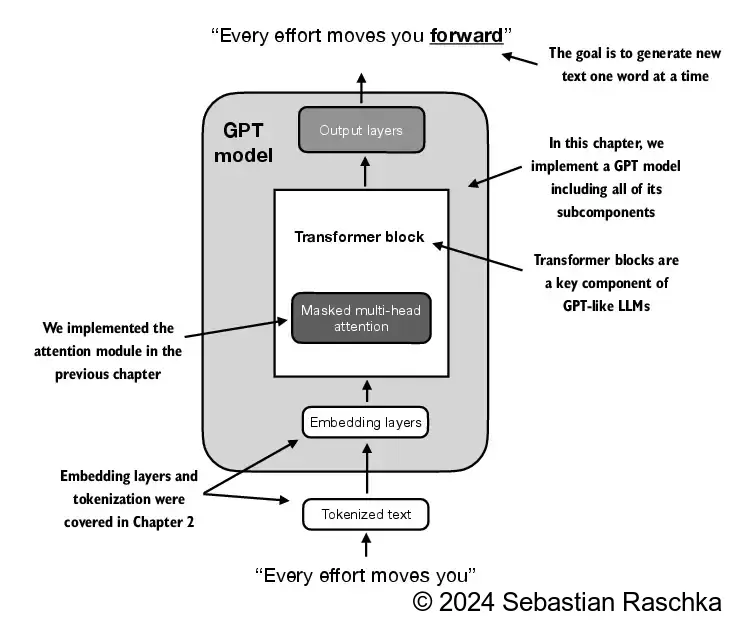
</div>

```py
Configuration details for the 124 million parameter GPT-2 model include:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}
```

**The numbered boxes shown in Figure illustrate the order in which we
tackle the individual concepts required to code the final GPT architecture**
<div style="text-align: center;">
  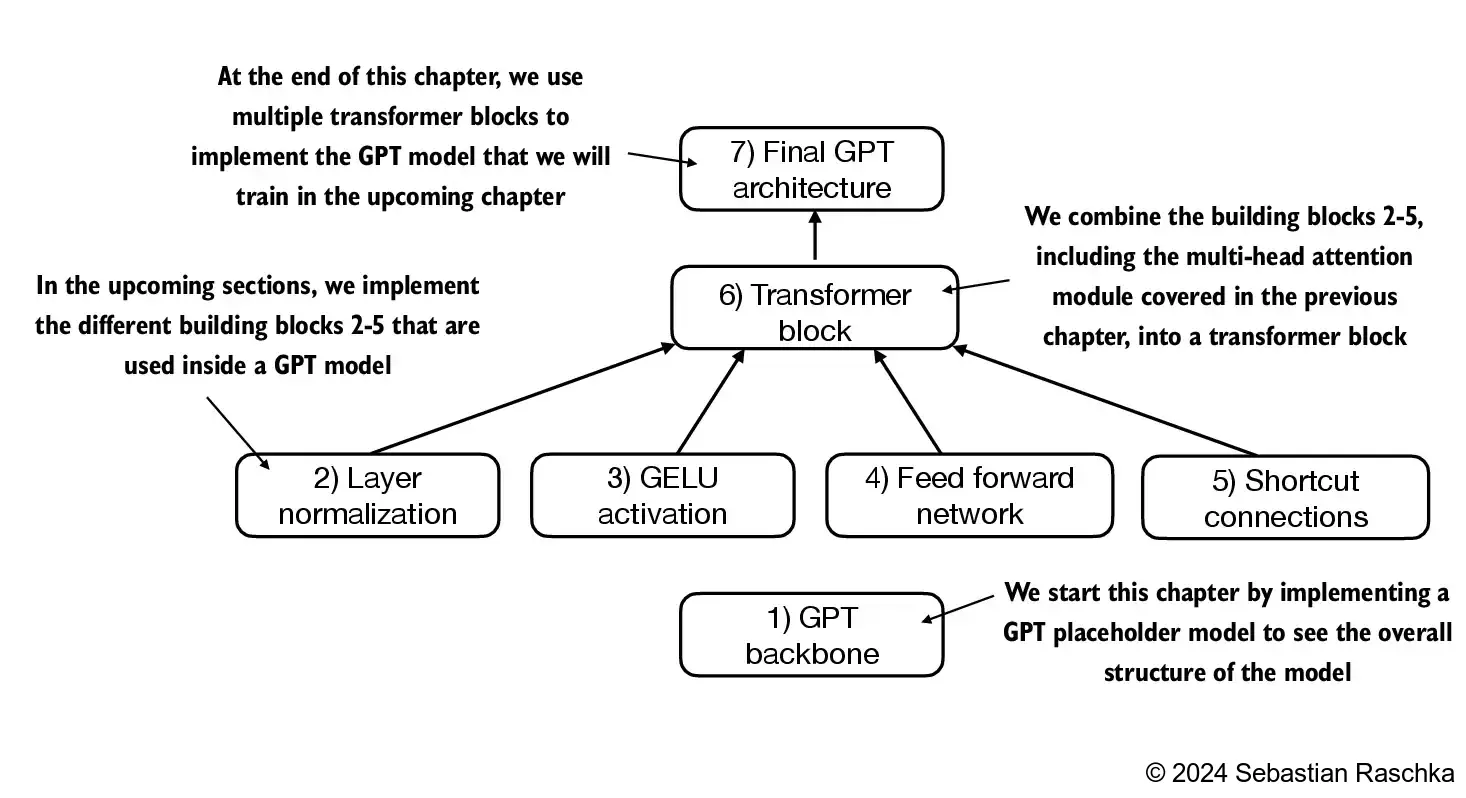
</div>

 <h3 style="background-color:#6A9C89; color:white; font-family:Gabriola; text-align:center; border-radius:50px; padding:15px 10px; font-size:38px;">
3.1) Layer Normalization </h3 >

> Training deep neural networks with many layers can sometimes prove
challenging due to issues like vanishing or exploding gradients. These issues
lead to unstable training dynamics and make it difficult for the network to
effectively adjust its weights, which means the learning process struggles to
find a set of parameters (weights) for the neural network that minimizes the
loss function. In other words, the network has difficulty learning the
underlying patterns in the data to a degree that would allow it to make
accurate predictions or decisions.


<div style="text-align: center;">
  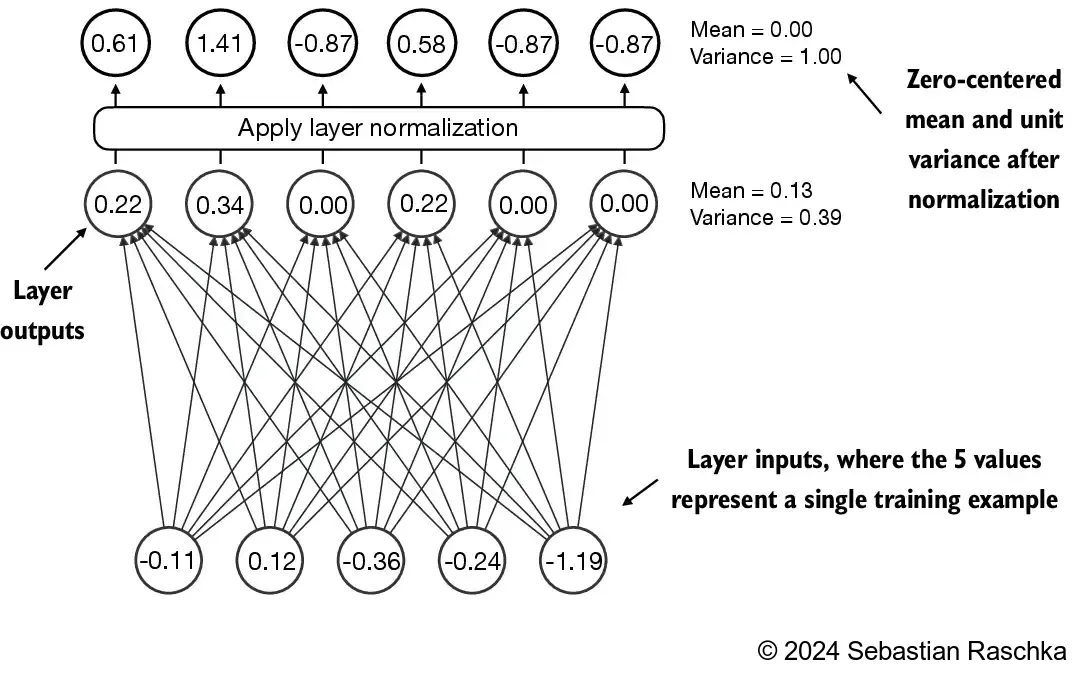
</div>


In [12]:
class LayerNorm(nn.Module):
    """
    Layer Normalization module.
    
    Args:
        emb_dim (int): The dimension of the input embeddings.
    
    Attributes:
        eps (float): A small value to avoid division by zero.
        scale (nn.Parameter): Learnable scale parameter.
        shift (nn.Parameter): Learnable shift parameter.
    """
    def __init__(self, emb_dim):
        super(LayerNorm, self).__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift


 <h3 style="background-color:#6A9C89; color:white; font-family:Gabriola; text-align:center; border-radius:50px; padding:15px 10px; font-size:38px;">
3.2) GELU activations </h3 >

* In deep learning, ReLU (Rectified Linear Unit) activation functions are commonly used due to their simplicity and effectiveness in various neural network architectures
* In LLMs, various other types of activation functions are used beyond the traditional ReLU; two notable examples are GELU (Gaussian Error Linear Unit) and SwiGLU (Swish-Gated Linear Unit)
* GELU and SwiGLU are more complex, smooth activation functions incorporating Gaussian and sigmoid-gated linear units, respectively, offering better performance for deep learning models, unlike the simpler, piecewise linear function of ReLU
* GELU (Hendrycks and Gimpel 2016) can be implemented in several ways; the exact version is defined as GELU(x)=x⋅Φ(x), where Φ(x) is the cumulative distribution function of the standard Gaussian distribution.
* In practice, it's common to implement a computationally cheaper approximation:

<math xmlns="http://www.w3.org/1998/Math/MathML">
  <mtext>GELU</mtext>
  <mo stretchy="false">(</mo>
  <mi>x</mi>
  <mo stretchy="false">)</mo>
  <mo>&#x2248;</mo>
  <mn>0.5</mn>
  <mo>&#x22C5;</mo>
  <mi>x</mi>
  <mo>&#x22C5;</mo>
  <mrow data-mjx-texclass="INNER">
    <mo data-mjx-texclass="OPEN">(</mo>
    <mn>1</mn>
    <mo>+</mo>
    <mi>tanh</mi>
    <mo data-mjx-texclass="NONE">&#x2061;</mo>
    <mrow data-mjx-texclass="INNER">
      <mo data-mjx-texclass="OPEN">[</mo>
      <msqrt>
        <mfrac>
          <mn>2</mn>
          <mi>&#x3C0;</mi>
        </mfrac>
      </msqrt>
      <mo>&#x22C5;</mo>
      <mrow data-mjx-texclass="INNER">
        <mo data-mjx-texclass="OPEN">(</mo>
        <mi>x</mi>
        <mo>+</mo>
        <mn>0.044715</mn>
        <mo>&#x22C5;</mo>
        <msup>
          <mi>x</mi>
          <mn>3</mn>
        </msup>
        <mo data-mjx-texclass="CLOSE">)</mo>
      </mrow>
      <mo data-mjx-texclass="CLOSE">]</mo>
    </mrow>
    <mo data-mjx-texclass="CLOSE">)</mo>
  </mrow>
</math>

In [13]:
class GELU(nn.Module):
    """
    Gaussian Error Linear Unit (GELU) activation function.
    This implementation follows the approximation:
    GELU(x) = 0.5 * x * (1 + tanh(sqrt(2/π) * (x + 0.044715 * x^3)))
    """
    def __init__(self):
        super(GELU, self).__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))
        ))

 <h3 style="background-color:#6A9C89; color:white; font-family:Gabriola; text-align:center; border-radius:50px; padding:15px 10px; font-size:38px;">
3.3)Feed Forward network</h3 >



In [14]:
class FeedForwardGELU(nn.Module):
    """
    A feed-forward neural network layer with GELU activation.
    
    Args:
        cfg (dict): Configuration dictionary with key 'emb_dim' representing the embedding dimension.
    
    The network consists of:
    - A linear layer projecting the input from 'emb_dim' to 4 * 'emb_dim'
    - GELU activation function
    - A linear layer projecting back to 'emb_dim'
    """
    def __init__(self, cfg):
        super(FeedForwardGELU, self).__init__()
        emb_dim = cfg.emb_dim
        
        self.layers = nn.Sequential(
            nn.Linear(emb_dim, 4 * emb_dim),
            GELU(),
            nn.Linear(4 * emb_dim, emb_dim),
        )

    def forward(self, x):
        return self.layers(x)


 <h3 style="background-color:#6A9C89; color:white; font-family:Gabriola; text-align:center; border-radius:50px; padding:15px 10px; font-size:38px;">
3.4) Adding shortcut connections</h3 >


* Next, let's talk about the concept behind shortcut connections, also called skip or residual connections
* Originally, shortcut connections were proposed in deep networks for computer vision (residual networks) to mitigate vanishing gradient problems
* A shortcut connection creates an alternative shorter path for the gradient to flow through the network
* This is achieved by adding the output of one layer to the output of a later layer, usually skipping one or more layers in between



<div style="text-align: center;">
  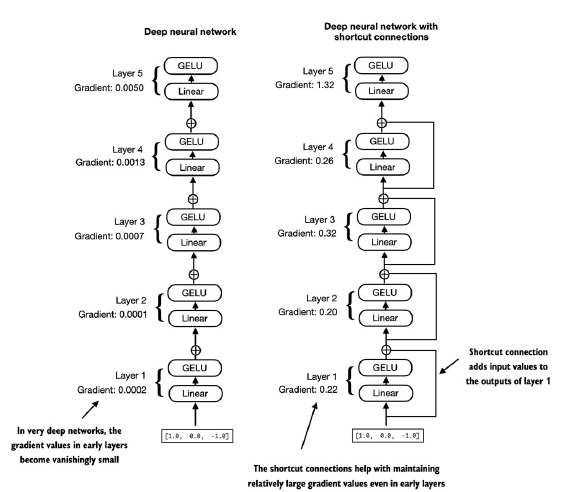
</div>



 <h3 style="background-color:#6A9C89; color:white; font-family:Gabriola; text-align:center; border-radius:50px; padding:15px 10px; font-size:38px;">
3.5) Transformer Block</h3 >

> **now, we are implementing the transformer block, a fundamental
 building block of GPT and other LLM architectures. This block, which is
 repeated a dozen times in the 124 million parameter GPT-2 architecture,
 combines several concepts we have previously covered: multi-head attention,
 layer normalization, dropout, feed forward layers, and GELU activations.we will then connect this
 transformer block to the remaining parts of the GPT architecture.**
<div style="text-align: center;">
  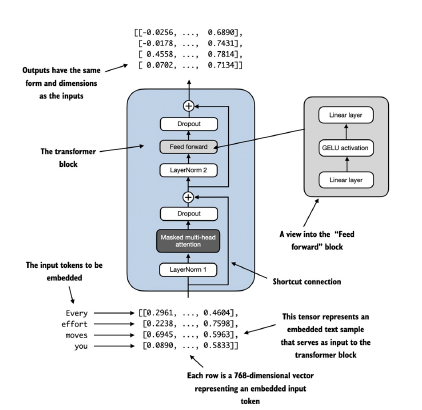
</div>


In [15]:
#  build Transformer architecture
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg.emb_dim,
            d_out=cfg.emb_dim,
            context_length=cfg.context_length,
            num_heads=cfg.n_heads,
            dropout=cfg.drop_rate,
            qkv_bias=cfg.qkv_bias)
        self.ff = FeedForwardGELU(cfg)
        self.norm1 = LayerNorm(cfg.emb_dim)
        self.norm2 = LayerNorm(cfg.emb_dim)
        self.dropout = nn.Dropout(cfg.drop_rate)

    def forward(self, x):

        resid_conn = x
        x = self.norm1(x)  # pre-LayerNorm
        x = self.att(x)
        x = self.dropout(x)
        x = x + resid_conn

        resid_conn = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.dropout(x)
        x = x + resid_conn
        return x

 <h3 style="background-color:#6A9C89; color:white; font-family:Gabriola; text-align:center; border-radius:50px; padding:15px 10px; font-size:38px;">
3.6) Final GPT architecture</h3 >


<div style="text-align: center;">
  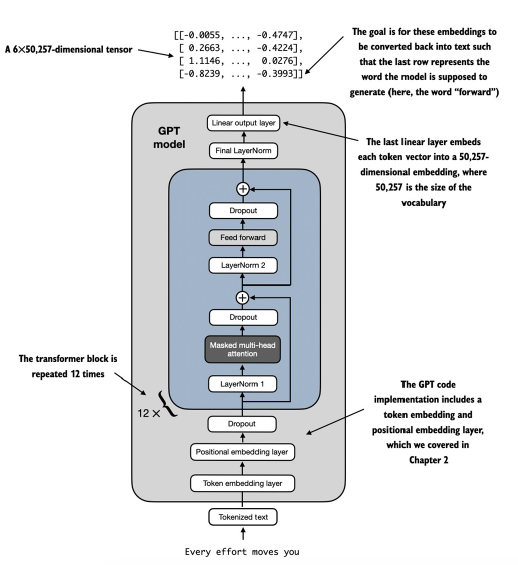
</div>

In [16]:
# then build the GPT Architecture based on your Config
class GPTModel(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg.vocab_size,cfg.emb_dim)
        self.pos_emb = nn.Embedding(cfg.context_length,cfg.emb_dim)
        self.dropout_emb = nn.Dropout(cfg.drop_rate)
        self.transformer_blocks = nn.Sequential( *[TransformerBlock(cfg) for _ in range(cfg.n_layers)])
        self.final_norm = LayerNorm(cfg.emb_dim)
        self.out_ff = nn.Linear(cfg.emb_dim,cfg.vocab_size,bias = False)

    def forward(self, idx):
        batch_size, seq_len = idx.shape
        tok_embeds = self.tok_emb(idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=idx.device))

        x = tok_embeds + pos_embeds
        x = self.dropout_emb(x)
        x = self.transformer_blocks(x)
        x = self.final_norm(x)
        logits = self.out_ff(x)
        return logits


 <h1 style="background-color:#0D7C66; color:white; font-family:Gabriola; text-align:center; border-radius:50px; padding:20px 40px; font-size:48px;">
 Stage 2
</h1>
 <h2 style="background-color:#41B3A2; color:white; font-family:Gabriola; text-align:center; border-radius:50px; padding:15px 10px; font-size:38px;">
4) Trainig Loop</h2 >


<div style="text-align: center;">
  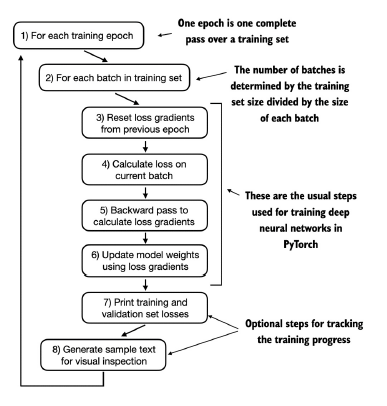
</div>

> Before write trainig function ,we need know how :
> - 1 Using GPT to generate text .
> - 2 Calculating the training and validation set losses.


### 1.Generate Function
- **we will cover text generation strategies (also called decoding strategies) to generate more original text.**
- **Then, we will cover two techniques, *temperature scaling*, and *top-k sampling*, to improve this function(*greedy*).**

In [17]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_token, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Get the idx of the vocab entry with the highest logits value
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx



def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float('-inf')).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx


def generate_and_print_sample(model, tokenizer, device, start_context,temperature, top_k, eos_id):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
#         token_ids = generate_text_simple(
#             model=model, idx=encoded,
#             max_new_tokens=50, context_size=context_size
#         )
         token_ids = generate(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size,
             temperature=temperature, top_k=top_k, eos_id=eos_id
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()
    


### 2.Calculating the training and validation set losses

In [18]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches


### Training and Evaluation method

In [19]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer,
                      temperature, top_k, eos_id):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        optimizer.zero_grad()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:03d}): "
                  f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        print("example: ")
        generate_and_print_sample(
            model, tokenizer, device, start_context,
            temperature, top_k, eos_id
        )
        print('-*-'*10)

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss



## Train Model

In [20]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)


torch.manual_seed(123)
model = GPTModel(GPTConfig)
model.to(device)
model.apply(initialize_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00009, weight_decay=0.1)
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

num_epochs = 50
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_dataloader, val_dataloader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves", tokenizer=tokenizer,
        top_k=10,temperature=0.4,eos_id=None
)

Ep 1 (Step 000): Train loss 10.559, Val loss 10.598
example: 
Every effort moves faces the PG nativesossipmoitten Speaking serious the theranking Pelicans replacementsRom Kyle Bi Gamb concerts, theRom furthe'''', the the the,  , Xavierenei theranking alk the, chorus arrive termination considerabletag,, the. the
-*--*--*--*--*--*--*--*--*--*-
example: 
Every effort moves facesHz--,,--. . the., the, the  he--,  the  the, Kyle destination., ., termination termination termination,  .,, the, termination,. the  he the of
-*--*--*--*--*--*--*--*--*--*-
example: 
Every effort moves,--, to  the he., the. the  the , , of,, the was  , was the, the      I the the he he, he.  the, he, he,
-*--*--*--*--*--*--*--*--*--*-
example: 
Every effort moves, it,,.,, I, to , the he the.. I.-- the,, to,,,-- the the, the  . the, , he   the I the the  the was to
-*--*--*--*--*--*--*--*--*--*-
example: 
Every effort moves the the  the was,-- to.  he,.. the the of of.,,. the was the the.,,. the of.-- was,--.    o

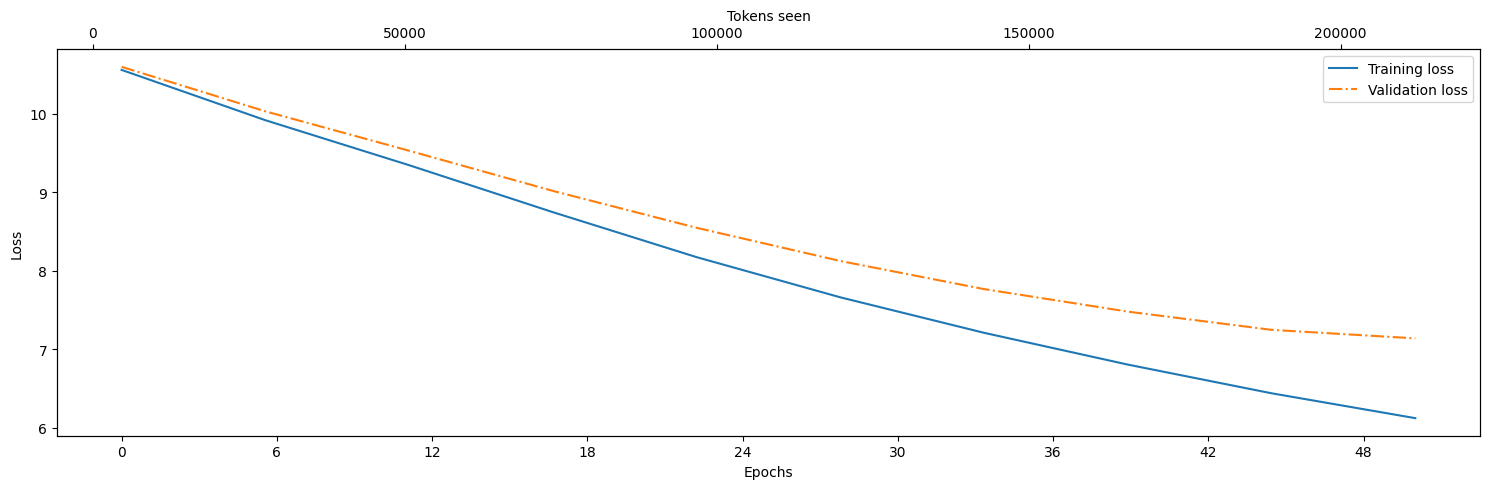

In [21]:
# Ep 46 (Step 045): Train loss 5.668, Val loss 6.691 ->4

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(15, 5))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [22]:
model.to("cpu")
model.eval()


token_ids = generate(
    model=model,
    idx=text_to_token_ids("quite insensible to the irony", tokenizer),
    max_new_tokens=25,
    context_size=GPTConfig.context_length,
    top_k=5,temperature=0.7,eos_id=None

)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 quite insensible to the irony, he, the of the of the.














"


 > 🚩 both the training and validation losses start to improve
for the first epoch. However, the losses start to diverge past the second epoch.
This divergence and the fact that the validation loss is much larger than the
training loss indicate that the model is overfitting to the training data. We can
confirm that the model memorizes the training data verbatim by searching for
the generated text snippets

<hr>

 <h2 style="background-color:#41B3A2; color:white; font-family:Gabriola; text-align:center; border-radius:50px; padding:15px 10px; font-size:38px;">
5) Loading and saving model weights in PyTorch</h2 >


* Training LLMs is computationally expensive, so it's crucial to be able to save and load LLM weights
* The recommended way in PyTorch is to save the model weights, the so-called state_dict via by applying the torch.save function to the .state_dict() method.
* These adaptive optimizers store additional parameters for each model weight, so it makes sense to save them as well in case we plan to continue the pretraining later.

In [23]:
# save model weight only:
# torch.save(model.state_dict(), "model.pth")
# # Then we can load the model weights into a new GPTModel model instance as follows:
# model = GPTModel(GPT_CONFIG_124M)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
# model.eval();

# save model weight and optimizer:
print('saving model and optimizer...')
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    }, 
    "model_and_optimizer.pth"
)
print('Done')

saving model and optimizer...
Done


In [24]:
#  delete model
del model

print(' then we deleted model from memory to ensure we use loaded model')

 then we deleted model from memory to ensure we use loaded model


In [25]:
# load model and optimizer
print('loading...')
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPTModel(GPTConfig)
model.to(device)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();
print('Done')

loading...
Done


In [26]:
#  now we can train again or use

num_epochs = 2
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_dataloader, val_dataloader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves ", tokenizer=tokenizer,
        top_k=10,temperature=2.7,eos_id=None
)

Ep 1 (Step 000): Train loss 5.804, Val loss 6.891
example: 
Every effort moves , I a _." , I-- the said. to--as the of, and he to-- I was had the the the the that the he's was, the I--. he had.  ,., in
-*--*--*--*--*--*--*--*--*--*-
example: 
Every effort moves , he's-- the that that Mrs. Gis " that,, of--, I he he was the picture: and I, it.  I had.  .    " a "I and, the to
-*--*--*--*--*--*--*--*--*--*-


 <h2 style="background-color:#41B3A2; color:white; font-family:Gabriola; text-align:center; border-radius:50px; padding:15px 10px; font-size:38px;">
6) Loading pretrained weights from OpenAI</h2 >

> - Previously, we only trained a small GPT-2 model using a very small short-story book for educational purposes.
> - Fortunately, we don't have to spend tens to hundreds of thousands of dollars to pretrain the model on a large pretraining corpus but can load the pretrained weights provided by OpenAI.


- we can load GPT from openAI by two Methods:
    * Tensorflow.
    * Transformer from HuggingFace.


 <h3 style="background-color:#74cdbf; color:white; font-family:Gabriola; text-align:center; border-radius:50px; padding:15px 10px; font-size:38px;">
6.1) Loading pretrained weights from OpenAI by Transformer</h3 >

In [27]:
from transformers import GPT2Model

gpt2_small=  "openai-community/gpt2"

gpt_hf = GPT2Model.from_pretrained(gpt2_small, cache_dir="checkpoints")
gpt_hf.eval()


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2SdpaAttention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [28]:
copyConfig = replace(GPTConfig)
copyConfig.qkv_bias =True
copyConfig.context_length =  1024
copyConfig.drop_rate= 0.0       
copyConfig

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.0,
    "qkv_bias": True
}

In [29]:
def assign_check(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(right.clone().detach())


In [30]:
def load_weights(gpt, gpt_hf):

    d = gpt_hf.state_dict()

    gpt.pos_emb.weight = assign_check(gpt.pos_emb.weight, d["wpe.weight"])
    gpt.tok_emb.weight = assign_check(gpt.tok_emb.weight, d["wte.weight"])
    
    for b in range(copyConfig.n_layers):
        q_w, k_w, v_w = np.split(d[f"h.{b}.attn.c_attn.weight"], 3, axis=-1)
        gpt.transformer_blocks[b].att.w_queries.weight = assign_check(gpt.transformer_blocks[b].att.w_queries.weight, q_w.T)
        gpt.transformer_blocks[b].att.w_keys.weight = assign_check(gpt.transformer_blocks[b].att.w_keys.weight, k_w.T)
        gpt.transformer_blocks[b].att.w_values.weight = assign_check(gpt.transformer_blocks[b].att.w_values.weight, v_w.T)
    
        q_b, k_b, v_b = np.split(d[f"h.{b}.attn.c_attn.bias"], 3, axis=-1)
        gpt.transformer_blocks[b].att.w_queries.bias = assign_check(gpt.transformer_blocks[b].att.w_queries.bias, q_b)
        gpt.transformer_blocks[b].att.w_keys.bias = assign_check(gpt.transformer_blocks[b].att.w_keys.bias, k_b)
        gpt.transformer_blocks[b].att.w_values.bias = assign_check(gpt.transformer_blocks[b].att.w_values.bias, v_b)
    
    
        gpt.transformer_blocks[b].att.out_proj.weight = assign_check(gpt.transformer_blocks[b].att.out_proj.weight, d[f"h.{b}.attn.c_proj.weight"].T)
        gpt.transformer_blocks[b].att.out_proj.bias = assign_check(gpt.transformer_blocks[b].att.out_proj.bias, d[f"h.{b}.attn.c_proj.bias"])
    
        gpt.transformer_blocks[b].ff.layers[0].weight = assign_check(gpt.transformer_blocks[b].ff.layers[0].weight, d[f"h.{b}.mlp.c_fc.weight"].T)
        gpt.transformer_blocks[b].ff.layers[0].bias = assign_check(gpt.transformer_blocks[b].ff.layers[0].bias, d[f"h.{b}.mlp.c_fc.bias"])
        gpt.transformer_blocks[b].ff.layers[2].weight = assign_check(gpt.transformer_blocks[b].ff.layers[2].weight, d[f"h.{b}.mlp.c_proj.weight"].T)
        gpt.transformer_blocks[b].ff.layers[2].bias = assign_check(gpt.transformer_blocks[b].ff.layers[2].bias, d[f"h.{b}.mlp.c_proj.bias"])
    
        gpt.transformer_blocks[b].norm1.scale = assign_check(gpt.transformer_blocks[b].norm1.scale, d[f"h.{b}.ln_1.weight"])
        gpt.transformer_blocks[b].norm1.shift = assign_check(gpt.transformer_blocks[b].norm1.shift, d[f"h.{b}.ln_1.bias"])
        gpt.transformer_blocks[b].norm2.scale = assign_check(gpt.transformer_blocks[b].norm2.scale, d[f"h.{b}.ln_2.weight"])
        gpt.transformer_blocks[b].norm2.shift = assign_check(gpt.transformer_blocks[b].norm2.shift, d[f"h.{b}.ln_2.bias"])
    
        gpt.final_norm.scale = assign_check(gpt.final_norm.scale, d[f"ln_f.weight"])
        gpt.final_norm.shift = assign_check(gpt.final_norm.shift, d[f"ln_f.bias"])
        gpt.out_ff.weight = assign_check(gpt.out_ff.weight, d["wte.weight"])

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gpt = GPTModel(copyConfig)
load_weights(gpt, gpt_hf)


In [32]:
# test
token_ids = generate(
    model=gpt.to(device),
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=30,
    context_size=copyConfig.context_length,
    top_k=1,
    temperature=1.0
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you forward.

The first step is to understand the importance of your work.

The second step is to understand the importance of your work.


In [33]:
del gpt
print('delete gpt model loaded from huggingface.')

delete gpt model loaded from huggingface.


 <h3 style="background-color:#74cdbf; color:white; font-family:Gabriola; text-align:center; border-radius:50px; padding:15px 10px; font-size:38px;">
6.2) Loading pretrained weights from OpenAI by Tensorflow</h3 >

In [34]:
import tensorflow as tf
import json

def download_file(url, destination):
    # Send a GET request to download the file

    try:
        with urllib.request.urlopen(url) as response:
            # Get the total file size from headers, defaulting to 0 if not present
            file_size = int(response.headers.get("Content-Length", 0))

            # Check if file exists and has the same size
            if os.path.exists(destination):
                file_size_local = os.path.getsize(destination)
                if file_size == file_size_local:
                    print(f"File already exists and is up-to-date: {destination}")
                    return

            # Define the block size for reading the file
            block_size = 1024  # 1 Kilobyte

            # Initialize the progress bar with total file size
            progress_bar_description = os.path.basename(url)  # Extract filename from URL
            with tqdm(total=file_size, unit="iB", unit_scale=True, desc=progress_bar_description) as progress_bar:
                # Open the destination file in binary write mode
                with open(destination, "wb") as file:
                    # Read the file in chunks and write to destination
                    while True:
                        chunk = response.read(block_size)
                        if not chunk:
                            break
                        file.write(chunk)
                        progress_bar.update(len(chunk))  # Update progress bar
    except urllib.error.HTTPError:
        s = (
            f"The specified URL ({url}) is incorrect, the internet connection cannot be established,"
            "\nor the requested file is temporarily unavailable.\nPlease visit the following website"
            " for help: https://github.com/rasbt/LLMs-from-scratch/discussions/273")
        print(s)

def load_gpt2_params_from_tf_ckpt(ckpt_path, settings):
    # Initialize parameters dictionary with empty blocks for each layer
    params = {"blocks": [{} for _ in range(settings["n_layer"])]}

    # Iterate over each variable in the checkpoint
    for name, _ in tf.train.list_variables(ckpt_path):
        # Load the variable and remove singleton dimensions
        variable_array = np.squeeze(tf.train.load_variable(ckpt_path, name))

        # Process the variable name to extract relevant parts
        variable_name_parts = name.split("/")[1:]  # Skip the 'model/' prefix

        # Identify the target dictionary for the variable
        target_dict = params
        if variable_name_parts[0].startswith("h"):
            layer_number = int(variable_name_parts[0][1:])
            target_dict = params["blocks"][layer_number]

        # Recursively access or create nested dictionaries
        for key in variable_name_parts[1:-1]:
            target_dict = target_dict.setdefault(key, {})

        # Assign the variable array to the last key
        last_key = variable_name_parts[-1]
        target_dict[last_key] = variable_array

    return params
def download_and_load_gpt2(model_size, models_dir):
    # Validate model size
    allowed_sizes = ("124M", "355M", "774M", "1558M")
    if model_size not in allowed_sizes:
        raise ValueError(f"Model size not in {allowed_sizes}")

    # Define paths
    model_dir = os.path.join(models_dir, model_size)
    base_url = "https://openaipublic.blob.core.windows.net/gpt-2/models"
    filenames = [
        "checkpoint", "encoder.json", "hparams.json",
        "model.ckpt.data-00000-of-00001", "model.ckpt.index",
        "model.ckpt.meta", "vocab.bpe"
    ]

    # Download files
    os.makedirs(model_dir, exist_ok=True)
    for filename in filenames:
        file_url = os.path.join(base_url, model_size, filename)
        file_path = os.path.join(model_dir, filename)
        download_file(file_url, file_path)

    # Load settings and params
    tf_ckpt_path = tf.train.latest_checkpoint(model_dir)
    settings = json.load(open(os.path.join(model_dir, "hparams.json")))
    params = load_gpt2_params_from_tf_ckpt(tf_ckpt_path, settings)

    return settings, params


In [35]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")


checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 37.5kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 935kiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 42.1kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [01:57<00:00, 4.22MiB/s]  
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 3.01MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 543kiB/s] 
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 586kiB/s] 


In [36]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])
[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [37]:
gpt = GPTModel(copyConfig)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (dropout_emb): Dropout(p=0.0, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (w_queries): Linear(in_features=768, out_features=768, bias=True)
        (w_keys): Linear(in_features=768, out_features=768, bias=True)
        (w_values): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForwardGELU(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (w_queries): Linea

In [38]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

def load_weights_into_gpt_tf(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
#      
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.transformer_blocks[b].att.w_queries.weight = assign(
            gpt.transformer_blocks[b].att.w_queries.weight, q_w.T)
        gpt.transformer_blocks[b].att.w_keys.weight = assign(
            gpt.transformer_blocks[b].att.w_keys.weight, k_w.T)
        gpt.transformer_blocks[b].att.w_values.weight = assign(
            gpt.transformer_blocks[b].att.w_values.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.transformer_blocks[b].att.w_queries.bias = assign(
            gpt.transformer_blocks[b].att.w_queries.bias, q_b)
        gpt.transformer_blocks[b].att.w_keys.bias = assign(
            gpt.transformer_blocks[b].att.w_keys.bias, k_b)
        gpt.transformer_blocks[b].att.w_values.bias = assign(
            gpt.transformer_blocks[b].att.w_values.bias, v_b)

        gpt.transformer_blocks[b].att.out_proj.weight = assign(
            gpt.transformer_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.transformer_blocks[b].att.out_proj.bias = assign(
            gpt.transformer_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.transformer_blocks[b].ff.layers[0].weight = assign(
            gpt.transformer_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.transformer_blocks[b].ff.layers[0].bias = assign(
            gpt.transformer_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.transformer_blocks[b].ff.layers[2].weight = assign(
            gpt.transformer_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.transformer_blocks[b].ff.layers[2].bias = assign(
            gpt.transformer_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.transformer_blocks[b].norm1.scale = assign(
            gpt.transformer_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.transformer_blocks[b].norm1.shift = assign(
            gpt.transformer_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.transformer_blocks[b].norm2.scale = assign(
            gpt.transformer_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.transformer_blocks[b].norm2.shift = assign(
            gpt.transformer_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_ff.weight = assign(gpt.out_ff.weight, params["wte"])
    
    
load_weights_into_gpt_tf(gpt, params)
gpt.to(device);


In [39]:
torch.manual_seed(123)
model.to(device)


num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    gpt, train_dataloader, val_dataloader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves ", tokenizer=tokenizer,
        top_k=5,temperature=0.7,eos_id=None
)

Ep 1 (Step 000): Train loss 3.634, Val loss 3.444
example: 
Every effort moves  and the result is the same. I'm not talking about a "good" game. I'm talking a game that's fun to play. It's not a game that's "bad" or "unbalanced". I'm talking a
-*--*--*--*--*--*--*--*--*--*-
example: 
Every effort moves  from one person to another. The first step is to make sure that the person who is doing the work doesn't do it in a bad way, or in a way that makes it seem like it's done. If the person who is working
-*--*--*--*--*--*--*--*--*--*-
example: 
Every effort moves  to the next stage. It is the first step of the journey, but it is not the end. The journey is long and the final step. It is the first step of the journey, but it is not the end. It
-*--*--*--*--*--*--*--*--*--*-
example: 
Every effort moves  to the front of the queue, and the queue is moved back to the queue. The queue is moved to a new location, where the queue is moved to. The queue is moved to a new location, where the queue 

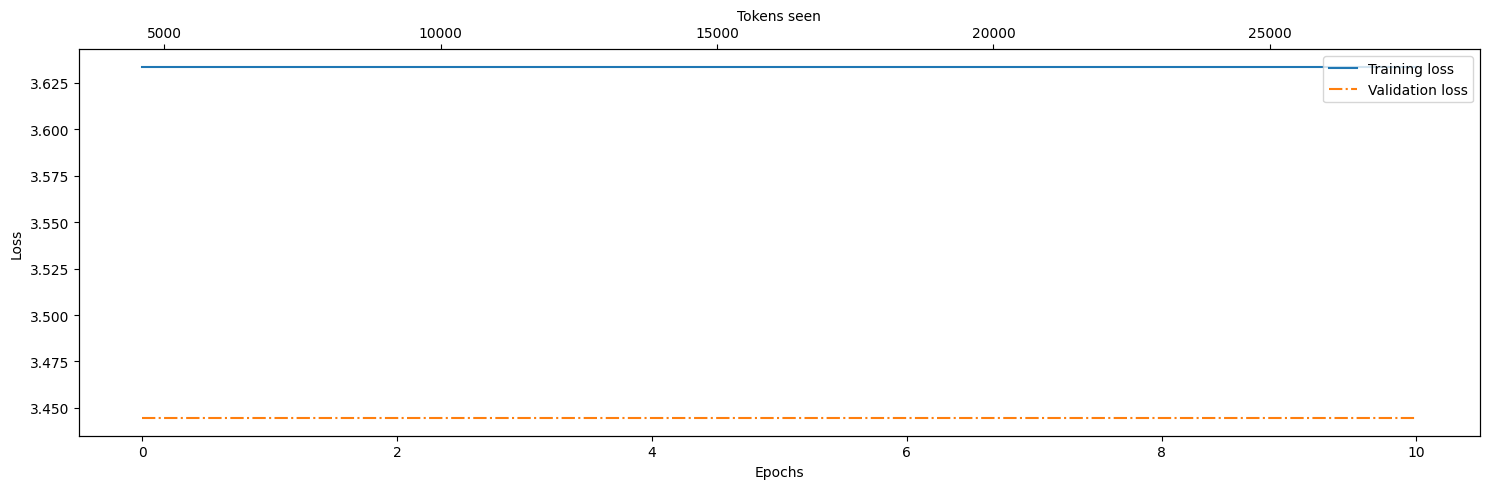

In [40]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [41]:
token_ids = generate(
    model=gpt.to(device),
    idx=text_to_token_ids("Every effort moves ", tokenizer).to(device),
    max_new_tokens=30,
    context_size=copyConfig.context_length,
    top_k=1,
    temperature=1.0
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves  to make the game more fun.
The game is a bit of a mess, but it's a fun game.
The game is a
